In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%%time 
df_train = pd.read_pickle('../input/feats/df_trn_feat0.pkl')

Wall time: 120 ms


In [3]:
%%time
df_test = pd.read_pickle('../input/feats/df_test_feat0.pkl')

Wall time: 36 ms


In [4]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability'],
      dtype='object')

In [5]:
df_trn = df_train.append(df_test)

interaction 

- uidx x param_1
- ~~uidx x image_top_1~~
- uidx x iidx
- ...

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import scipy.sparse as sp

In [7]:
def make_inter_svd(df,inter_cols, latent=5):
    assert len(inter_cols) == 2
    
    ### label encode (col2) ###
    
    col1, col2 = inter_cols[0],inter_cols[1]
    print('doing label encode {} ...'.format(col2), end='\t')
    df['hash'] = df[col2].apply(lambda x:hash(x)).astype('str') ## 必須為string
    label_encode_col = col2 + '_label'
    df[label_encode_col] = LabelEncoder().fit_transform(df['hash']).astype('uint16')
    print('ok')
    
    ### groupby count ####
    print('doing groupby "{},{}" count...'.format(*inter_cols), end='\t')
    gb_cnt = 'cnt_by_{}_{}'.format(*inter_cols)
    
    df_gb_cnt = df.groupby(inter_cols).size().astype('int32').\
        reset_index().rename(columns={0:gb_cnt})
    df = df.merge(df_gb_cnt, how='left', on= inter_cols)
    df[gb_cnt] = df[gb_cnt].fillna(0).apply(np.log1p).astype('float16') ## np.log1p ###
    print('ok')
    
    ### built interaction sparse coo matrix (col1 x col2)##
    print('build interactio spare matrix...')
    I = df[col1].as_matrix()
    J = df[label_encode_col].as_matrix()
    V = df[gb_cnt].as_matrix()

    inter_sp = sp.coo_matrix((V,(I,J)),dtype='float16')
    
    plt.spy(inter_sp,markersize=0.1,aspect='auto') 
    
    print('build tsvd to n_dim={}...'.format(latent),end='\t')
    svd = TruncatedSVD(n_components=latent, random_state=0)
    inter_svd = svd.fit_transform(inter_sp)
    print('ok')
    
    ### map tsvd result to df 
    print('map to df...')
    df_inter_tmp = pd.DataFrame(inter_svd)
    df_inter_tmp.columns = ['inter_svd_{}_{}_label_{}'.format(col1,col2,i) for i in range(latent)]
    df_inter_tmp[col1] = range(inter_svd.shape[0])
    
    df = df.merge(df_inter_tmp,how='left',on=col1)
    print('complete')
    df.drop('hash',axis=1,inplace=True)
    return df

##### uidx x param_1

doing label encode param_1 ...	ok
doing groupby "uidx,param_1" count...	ok
build interactio spare matrix...
build tsvd to n_dim=5...	ok
map to df...
complete


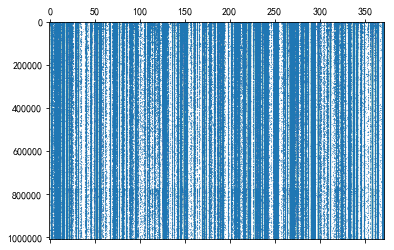

In [8]:
latent =5 
df = make_inter_svd(df_trn,['uidx','param_1'],latent=latent)

In [9]:
selcols =['inter_svd_uidx_param_1_label_{}'.format(e) for e in range(latent)]
df[selcols+['deal_probability']].corr().deal_probability

inter_svd_uidx_param_1_label_0   -0.026865
inter_svd_uidx_param_1_label_1   -0.018579
inter_svd_uidx_param_1_label_2   -0.020648
inter_svd_uidx_param_1_label_3   -0.014176
inter_svd_uidx_param_1_label_4   -0.015736
deal_probability                  1.000000
Name: deal_probability, dtype: float64

In [17]:
df[['cnt_by_uidx_param_1','deal_probability']].corr()

,cnt_by_uidx_param_1,deal_probability
cnt_by_uidx_param_1,1.000000,-0.170252
deal_probability,-0.170252,1.000000


#####  uidx x iidx

doing label encode iidx ...	ok
doing groupby "uidx,iidx" count...	ok
build interactio spare matrix...
build tsvd to n_dim=5...	ok
map to df...
complete


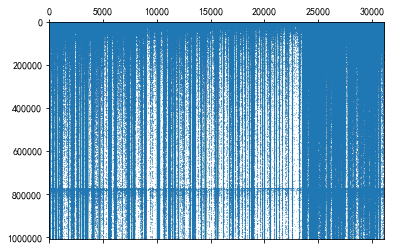

In [18]:
df = make_inter_svd(df,['uidx','iidx'])

In [19]:
df.columns

Index(['activation_date', 'ads_cnt_by_iid', 'ads_cnt_by_uid', 'category_name',
       'day', 'deal_probability', 'desc_len', 'iid', 'iidx', 'image_top_1',
       'month', 'param_1', 'param_2', 'param_3', 'parent_category_name',
       'price', 'region_city_label', 'tit_len', 'uidx', 'user_type', 'weekday',
       'param_1_label', 'cnt_by_uidx_param_1',
       'inter_svd_uidx_param_1_label_0', 'inter_svd_uidx_param_1_label_1',
       'inter_svd_uidx_param_1_label_2', 'inter_svd_uidx_param_1_label_3',
       'inter_svd_uidx_param_1_label_4', 'iidx_label', 'cnt_by_uidx_iidx',
       'inter_svd_uidx_iidx_label_0', 'inter_svd_uidx_iidx_label_1',
       'inter_svd_uidx_iidx_label_2', 'inter_svd_uidx_iidx_label_3',
       'inter_svd_uidx_iidx_label_4'],
      dtype='object')

In [20]:
selcols = ['inter_svd_uidx_iidx_label_{}'.format(e) for e in range(latent)]
y_ = ['deal_probability']
df[selcols+ y_].corr()[y_]

,deal_probability
inter_svd_uidx_iidx_label_0,-0.005246
inter_svd_uidx_iidx_label_1,-0.078662
inter_svd_uidx_iidx_label_2,-0.061028
inter_svd_uidx_iidx_label_3,-0.052466
inter_svd_uidx_iidx_label_4,-0.048465
deal_probability,1.000000


#####  save

In [21]:
df.columns

Index(['activation_date', 'ads_cnt_by_iid', 'ads_cnt_by_uid', 'category_name',
       'day', 'deal_probability', 'desc_len', 'iid', 'iidx', 'image_top_1',
       'month', 'param_1', 'param_2', 'param_3', 'parent_category_name',
       'price', 'region_city_label', 'tit_len', 'uidx', 'user_type', 'weekday',
       'param_1_label', 'cnt_by_uidx_param_1',
       'inter_svd_uidx_param_1_label_0', 'inter_svd_uidx_param_1_label_1',
       'inter_svd_uidx_param_1_label_2', 'inter_svd_uidx_param_1_label_3',
       'inter_svd_uidx_param_1_label_4', 'iidx_label', 'cnt_by_uidx_iidx',
       'inter_svd_uidx_iidx_label_0', 'inter_svd_uidx_iidx_label_1',
       'inter_svd_uidx_iidx_label_2', 'inter_svd_uidx_iidx_label_3',
       'inter_svd_uidx_iidx_label_4'],
      dtype='object')

In [22]:
latent =5
inter_1 = ['inter_svd_uidx_param_1_label_{}'.format(e) for e in range(latent)]
inter_2 = ['inter_svd_uidx_iidx_label_{}'.format(e) for e in range(latent)]


In [23]:
feat2_inter_cols = inter_1 + inter_2 + ['cnt_by_uidx_param_1']
print('\n'.join(feat2_inter_cols))

inter_svd_uidx_param_1_label_0
inter_svd_uidx_param_1_label_1
inter_svd_uidx_param_1_label_2
inter_svd_uidx_param_1_label_3
inter_svd_uidx_param_1_label_4
inter_svd_uidx_iidx_label_0
inter_svd_uidx_iidx_label_1
inter_svd_uidx_iidx_label_2
inter_svd_uidx_iidx_label_3
inter_svd_uidx_iidx_label_4
cnt_by_uidx_param_1


In [28]:
len_train = df_train.shape[0]
len_test  = df_test.shape[0]
print('len of train:{}, test:{}'.format(len_train,len_test))

len of train:1503424, test:508438


In [35]:
store = pd.HDFStore('../input/feats/feat2_trn_inter_svd.h5')
store['df_trn_inter_svd'] = df.iloc[:len_train,:][feat2_inter_cols]
store['df_test_inter_svd'] = df.iloc[len_train:,:][feat2_inter_cols]
store.close()

____

In [18]:
# from libfm import *